In [77]:
import pandas as pd
import numpy as np
import ast
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [59]:
comment_data = pd.read_csv(r'C:\Users\User\Desktop\Прога\Питон\аналитика вк\парсинг вк\parsing_comments.csv')
group_data = pd.read_csv(r'C:\Users\User\Desktop\Прога\Питон\аналитика вк\парсинг вк\group_data_processed')

In [60]:
group = group_data[['id', 'group_names']]
group = group.rename(columns={'id':'post_id'})

In [61]:
comment_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [62]:
comment_data['reply_to_user'] =  comment_data['reply_to_user'].apply(lambda x: 0 if pd.isna(x) else 1)
comment_data['attachments'] =  comment_data['attachments'].apply(lambda x: 0 if pd.isna(x) else 1)
comment_data['reply_to_comment'] =  comment_data['reply_to_comment'].apply(lambda x: 0 if pd.isna(x) else 1)
comment_data['likes'] = comment_data['likes'].apply(lambda x: ast.literal_eval(x)['count'])

In [63]:
comment_data.head()

,id,from_id,date,text,likes,attachments,reply_to_user,reply_to_comment,post_id
0,3805179.0,195344144.0,1.623586e+09,"Подтверждаю, всё именно так",229,1,0,0,3805176
1,3805180.0,607883670.0,1.623586e+09,It's Roman Pavlov toilet,81,0,0,0,3805176
2,3805184.0,365911915.0,1.623586e+09,Souz umoristov Pavlova,17,0,0,0,3805176
3,3805188.0,46042277.0,1.623586e+09,"У нас в школах и общагах толчки хуже, здесь хо...",10,0,0,0,3805176
4,3805191.0,407117419.0,1.623586e+09,"[id195344144|Роман], пикчу мог и не менять",2,0,1,1,3805176


Сгруппируем все комментарии под постом в один текст, так алгоритму будет проще предсказывать, из какой группы пришел текст

In [64]:
comment_data.dropna(inplace=True)

In [65]:
all_comments = comment_data.groupby('post_id', as_index=False)['text', 'likes'].agg({'text':lambda x: ' '.join(x), 'likes':'sum'})

<ipython-input-65-30baf7505034>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_comments = comment_data.groupby('post_id', as_index=False)['text', 'likes'].agg({'text':lambda x: ' '.join(x), 'likes':'sum'})


In [66]:
all_comments = all_comments.merge(group, on='post_id', how='left')

In [67]:
all_comments.head()

,post_id,text,likes,group_names
0,3776190,а типа можно мемы на другую тематику? или вы т...,1202,Reddit
1,3776341,"Gym She is not Black [id196733033|Андрей], [id...",9642,Reddit
2,3776941,"Какие сообщения приходят мне😭: Я, когда вижу, ...",2319,Reddit
3,3777082,Нужно было скачать sandwich.png и по Bluetooth...,315,Reddit
4,3777189,Так и вычисляют муравьев с кислыми попками аха...,376,Reddit


In [68]:
def preprocessing_text(texts):
    my_words = set({'это', "который", "комментарий", "новый", "год", "просто", "человек", "такой", "быть", "александр", "никита", "удалой", "пользователь", "роман", "н", "ч", "л", "м","знать","свой", "твой", "ещ"})
    eng = set(stopwords.words('english'))
    rus = set(stopwords.words('russian'))
    stop = eng | rus | my_words
    
    regex = re.compile('[^а-яА-Я]')
    preprocess_texts = []
    for i in  tqdm.tqdm(range(len(texts))):
        text = texts[i].lower()
        text = regex.sub(' ', text)
        word_tokens = word_tokenize(text)
        filtered_str = [w for w in word_tokens if not w in stop] 
        preprocess_texts.append( ' '.join(filtered_str))
    
    return preprocess_texts

In [69]:
def text_lem(texts):
    lem = pymorphy2.MorphAnalyzer()
    lem_text = []
    for text in tqdm.tqdm(texts):
        tokenised_text = word_tokenize(text)
        lem_text.append(' '.join([lem.parse(word)[0].normal_form for word in tokenised_text]))
    return lem_text

Выполним предобработку текста: приведем все к нижнему регистру, удалим стоп слова, и оставим только символы из русского алфавита 

In [70]:
all_comments['text'].fillna('', inplace=True)
all_comments['text'] = preprocessing_text(all_comments['text'])
all_comments['text'] = text_lem(all_comments['text'])

100%|██████████| 7948/7948 [19:11<00:00,  6.90it/s]  


In [71]:
all_comments['text'] = preprocessing_text(all_comments['text'])

100%|██████████| 7948/7948 [00:47<00:00, 168.12it/s]


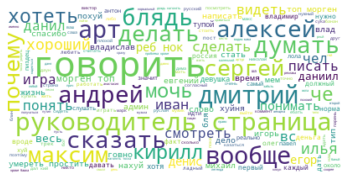

In [78]:
text = " ".join(desc for desc in all_comments.text)
wordcloud = WordCloud(background_color="white").generate(text)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Самые часто встречающиеся слова в тексте 

In [72]:
from collections import Counter

text = Counter((' '.join(all_comments['text'])).split())
text = dict(text)

In [73]:
df = pd.DataFrame({'names': text.keys(), 'count':text.values()})
df = df.sort_values(by='count', ascending=False)
two_words = len(df[df['count'] > 2])

Векторизируем наши слова, для этого применим TF-IDF преобразование

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [75]:
text = all_comments['text'].values.astype('U')
max_features = two_words
X = vectorize(text, maxx_features=max_features)
X.shape

(7948, 37829)

In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(7948, 5803)

In [87]:
pd.DataFrame(X_reduced).to_csv(r'C:\Users\User\Desktop\Прога\Питон\аналитика вк\pca2.csv')

In [3]:
X_reduced = pd.read_csv(r'C:\Users\User\Desktop\Прога\Питон\аналитика вк\pca2.csv')

In [8]:
X_reduced.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
X_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,5793,5794,5795,5796,5797,5798,5799,5800,5801,5802
0,-0.071656,-0.021317,-0.020030,0.017108,-0.028313,0.015334,0.022514,0.046449,0.026850,-0.015071,...,0.004975,-0.002674,0.001797,0.000172,-0.001875,0.003555,-0.006171,-0.012228,0.002714,-0.004327
1,0.029549,-0.094144,0.031843,-0.099707,0.044290,0.027767,0.053492,0.090551,-0.034055,0.010361,...,-0.002328,0.012251,0.005436,-0.001586,-0.011187,0.000685,0.006290,-0.001464,-0.007593,-0.000786
2,-0.049671,-0.006742,0.000078,-0.005857,0.004150,-0.083846,0.074182,-0.009250,0.038440,0.001945,...,0.011714,0.011408,-0.003304,-0.003359,0.005384,0.003472,-0.003672,-0.014114,-0.004189,0.005007
3,-0.052063,0.029546,-0.027144,0.005533,0.012263,-0.002899,0.001401,0.033719,-0.016696,0.000256,...,-0.000357,0.003198,0.002299,0.007463,0.000954,-0.005948,0.002446,-0.000272,-0.001158,0.000314
4,-0.052866,0.015545,-0.044781,-0.023150,-0.003006,-0.017144,0.007846,0.178134,0.157541,0.084278,...,0.005140,0.003584,-0.005759,-0.004179,-0.002444,-0.008350,-0.001708,0.001004,0.001819,-0.002871


In [10]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [11]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(3, 15)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=43).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X_reduced.shape[0])

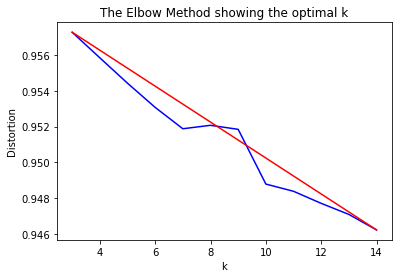

In [12]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

По методу локтя заметим, что оптимальное количество кластеров равно 10

In [27]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
all_comments['cluster'] = y_pred

For n_clusters = 10 The average silhouette_score is : 0.0017528196012999524


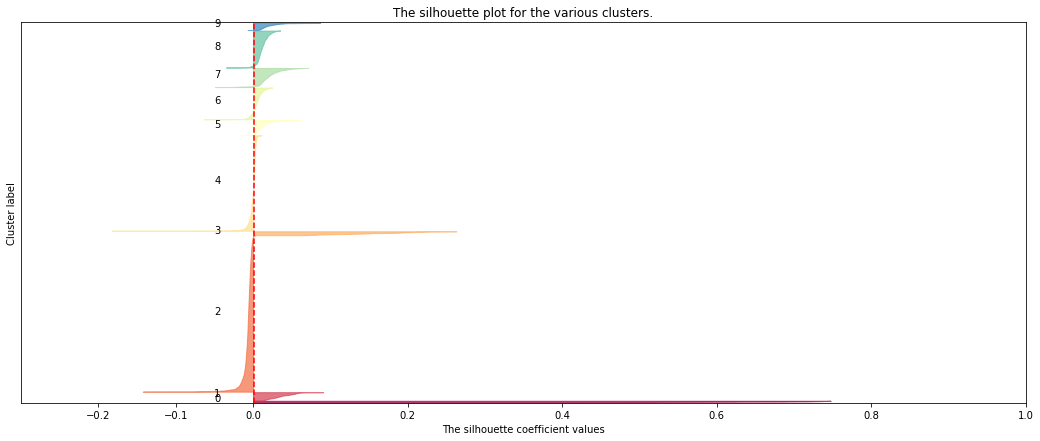

In [83]:
range_n_clusters = [10]

for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.3, 1])
    ax1.set_ylim([0, len(X_reduced) + (n_clusters + 1) * 10])
    cluster_labels = y_pred
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)

        # color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    plt.show()

Из за большой разряженности в данных silhouette_score получился очень маленьким

In [28]:
all_comments.to_csv(r'C:\Users\User\Desktop\Прога\Питон\аналитика вк\processed comment data.csv')

In [46]:
all_comments[all_comments['cluster']==2]

,post_id,text,likes,group_names,cluster
0,3776190,тип мем тематика кидать подряд прикол мочь объ...,1202,Reddit,2
2,3776941,сообщение приходить видеть деревня атаковать а...,2319,Reddit,2
3,3777082,нужно скачать передать телефон практически каж...,315,Reddit,2
5,3777297,друг друг смотреть видеосвязь любовь возраст п...,611,Reddit,2
9,3777753,павлов спать первый черви австралия тангир лох...,1137,Reddit,2
...,...,...,...,...,...
7937,75206352,руководитель страница чат емая страшный лола п...,188,NaN,2
7938,75207344,ноунейм содать лав общий иууа руководитель стр...,303,Овсянка,2
7939,75209183,крутой собака кросс необычный котонайк получат...,10,Овсянка,2
7940,75209525,бояться чеченец бояться чеченец мафия нахуй ни...,58,Овсянка,2


In [47]:
all_comments.cluster.value_counts()

2    3303
4    2021
8     783
6     671
7     405
5     321
1     172
9     154
3      84
0      34
Name: cluster, dtype: int64

In [32]:
data = all_comments.groupby(['group_names', 'cluster'], as_index=False)['post_id'].count().sort_values(by='post_id', ascending=False)

<AxesSubplot:xlabel='group_names', ylabel='post_id'>

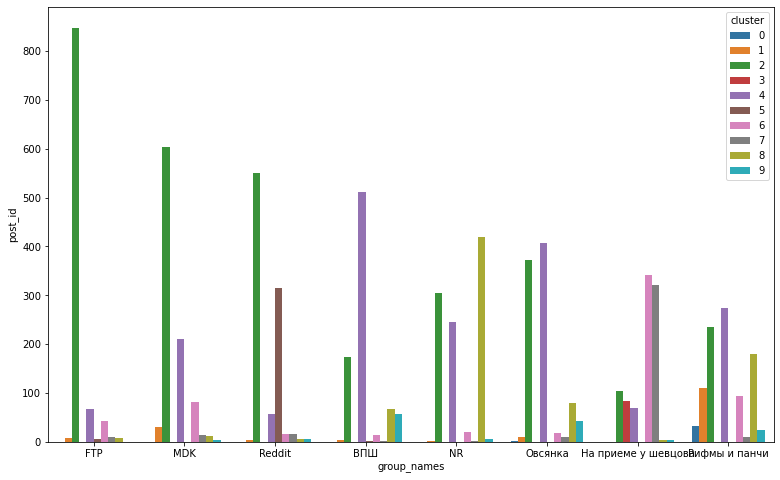

In [33]:
plt.figure(figsize=(13, 8))
sns.barplot(data=data, x='group_names', y='post_id', hue='cluster')

Посмотрим на самые популярные слова в разрезе кластеров

In [34]:
df = all_comments.groupby('cluster')['text'].agg(lambda x: ''.join(str(x)))
df

cluster
0    4772    скоро разъ б ощущение гей мальчик крас...
1    147     казаться украина казаться прич украина...
2    0       тип мем тематика кидать подряд прикол ...
3    973     естись рот владимир пойти нахуй даниил...
4    1       андрей андрей бравть страрс денис геор...
5    4       вычислять муравей кислый попка ахахи а...
6    37      канада влад ездить канада почитать пря...
7    113     баттл кс место перепутать наверное люб...
8    139     товарищ следователь попросить андрей у...
9    24      атаковать вертол радиус км давать уррр...
Name: text, dtype: object

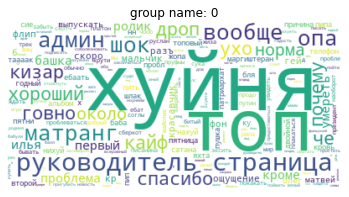

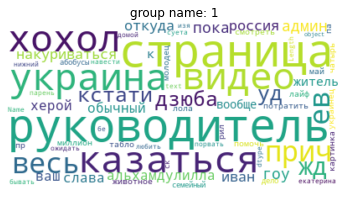

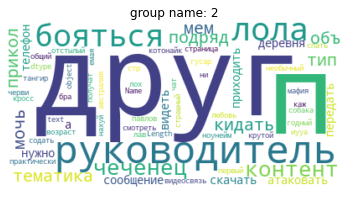

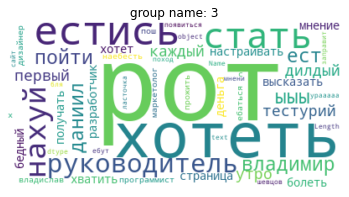

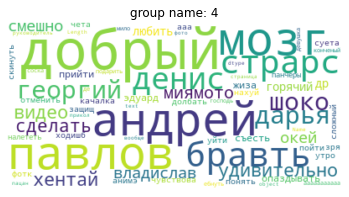

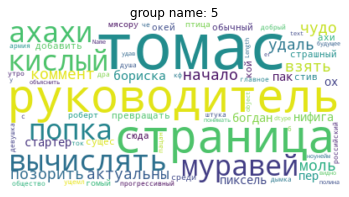

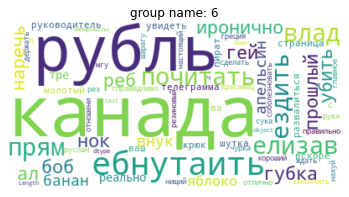

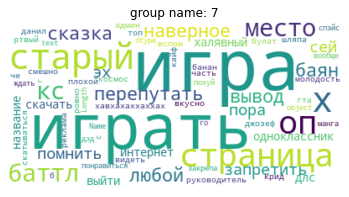

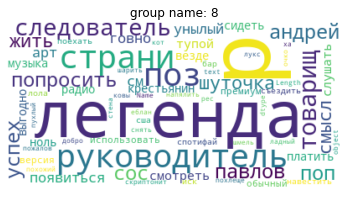

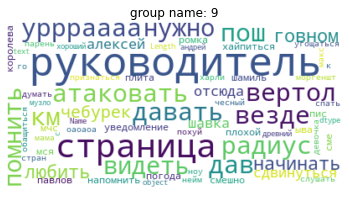

In [35]:
for group, text in df.items():
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('group name: {}'.format(group))
    plt.show()